In [ ]:
! nvidia-smi

In [ ]:
! pip install keras-tuner

In [48]:
import tensorflow
from tensorflow import keras
import kerastuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Some utility functions

In [6]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

### Squeeze Excite Block

In [7]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Dataset 1

In [13]:
def MLSTM_FCN():
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(118, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
    model.summary()

    return model

model = MLSTM_FCN()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 128, 6)       0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 128, 128)     6272        permute_3[0][0]                  
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 128, 128)     512         conv1d_9[0][0]                   
____________________________________________________________________________________________

In [ ]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6743597388267517
Test accuracy: 0.9323529601097107


> Accuracy achived: 97.37 (Previous best: 97.33)

# Dataset 2

In [14]:
def MLSTM_FCN():
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(20, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
    model.summary()

    return model

model = MLSTM_FCN()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 128, 6)       0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 128, 128)     6272        permute_4[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 128)     512         conv1d_12[0][0]                  
____________________________________________________________________________________________

Epoch 1/100
78/78 [==============================] - 48s 99ms/step - loss: 1.4832 - accuracy: 0.6207 - val_loss: 1.6609 - val_accuracy: 0.4777
Epoch 2/100
78/78 [==============================] - 6s 73ms/step - loss: 0.1725 - accuracy: 0.9665 - val_loss: 0.8986 - val_accuracy: 0.7709
Epoch 3/100
78/78 [==============================] - 6s 73ms/step - loss: 0.0790 - accuracy: 0.9838 - val_loss: 0.3074 - val_accuracy: 0.9447
Epoch 4/100
78/78 [==============================] - 6s 73ms/step - loss: 0.0510 - accuracy: 0.9893 - val_loss: 0.0782 - val_accuracy: 0.9869
Epoch 5/100
78/78 [==============================] - 6s 74ms/step - loss: 0.0385 - accuracy: 0.9912 - val_loss: 0.0919 - val_accuracy: 0.9743
Epoch 6/100
78/78 [==============================] - 6s 74ms/step - loss: 0.0306 - accuracy: 0.9924 - val_loss: 0.0423 - val_accuracy: 0.9885
Epoch 7/100
78/78 [==============================] - 6s 74ms/step - loss: 0.0292 - accuracy: 0.9929 - val_loss: 0.0362 - val_accuracy: 0.9901
Epoch

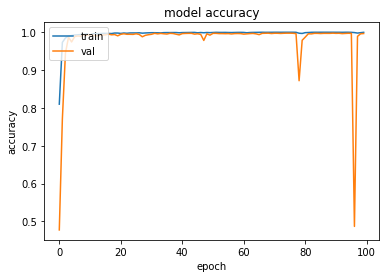

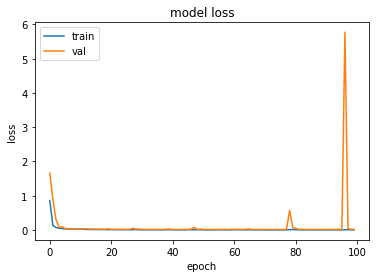

In [15]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
score = model.evaluate(X_test, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22146883606910706
Test accuracy: 0.9736629128456116


### Now it's Time for Keras Tuner!

As we couldn't beat the dataset 2, so we tuned the hyperparameters.

In [55]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')

In [56]:
def MLSTM_FCN_tuned(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(118, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

In [57]:
tuner = kt.tuners.RandomSearch(
    MLSTM_FCN_tuned,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='MLSTM_FCN')

tuner.search(X_train, train_label, epochs=100, validation_split=0.1, callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)])

Trial 10 Complete [00h 19m 23s]
val_accuracy: 0.99516761302948

Best val_accuracy So Far: 0.9966777563095093
Total elapsed time: 02h 15m 32s
INFO:tensorflow:Oracle triggered exit


In [58]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 6)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 128)     6272        permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128)     512         conv1d[0][0]                     
______________________________________________________________________________________________

In [62]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters

In [63]:
model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_tuned.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
59/59 [==============================] - 10s 96ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0306 - val_accuracy: 0.9949
Epoch 2/100
59/59 [==============================] - 4s 73ms/step - loss: 7.5259e-04 - accuracy: 0.9998 - val_loss: 0.0252 - val_accuracy: 0.9964
Epoch 3/100
59/59 [==============================] - 4s 73ms/step - loss: 5.8160e-04 - accuracy: 0.9998 - val_loss: 0.0240 - val_accuracy: 0.9967
Epoch 4/100
59/59 [==============================] - 4s 73ms/step - loss: 4.7363e-04 - accuracy: 0.9999 - val_loss: 0.0235 - val_accuracy: 0.9964
Epoch 5/100
59/59 [==============================] - 4s 74ms/step - loss: 3.9967e-04 - accuracy: 0.9999 - val_loss: 0.0233 - val_accuracy: 0.9964
Epoch 6/100
59/59 [==============================] - 4s 74ms/step - loss: 4.3300e-04 - accuracy: 0.9999 - val_loss: 0.0231 - val_accuracy: 0.9964
Epoch 7/100
59/59 [==============================] - 4s 74ms/step - loss: 3.2105e-04 - accuracy: 0.9999 - val_loss: 0.0230 - va

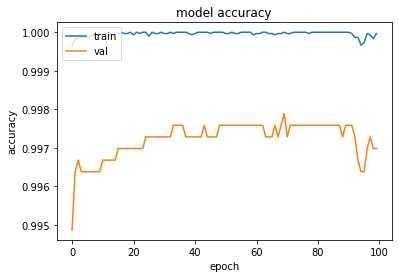

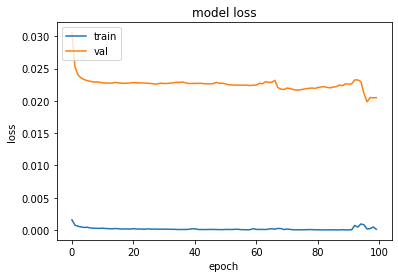

In [64]:
history = model.fit(X_train, train_label, validation_split = 0.1, epochs=100, shuffle=True, batch_size=512, callbacks=tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
score = model.evaluate(X_test, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6833741068840027
Test accuracy: 0.9430481195449829


> Accuracy achived: 94.30 (Previous best: 93.52)